In [1]:
# import data 
import numpy as np
import pandas as df
np_folder = 'PRSA_seasons/PRSA_Wanshouxigong_numpy_winter'
np_split = np_folder.split('/')
np_file = np_split[1]
splitter = np_file.split('_')
display_name = splitter[0] + '_' + splitter[1]
hi = np.load('PRSA_seasons/' + np_file + '.npy', allow_pickle=True)

dataframeee = df.DataFrame(hi)
dataframeee.columns = ['No', 'year', 'month','day', 'hour','PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']
dataframeee.to_csv(display_name + '.csv', index=False) # comma separated


In [2]:
import pandas as pd
from datetime import datetime
import io

# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
 
# dataset = pd.read_csv(io.BytesIO(uploaded[hello]),  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset = pd.read_csv(display_name + '.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.drop('PM10', axis=1, inplace=True)
dataset.drop('SO2', axis=1, inplace=True)
dataset.drop('CO', axis=1, inplace=True)
dataset.drop('NO2', axis=1, inplace=True)
dataset.drop('O3', axis=1, inplace=True)
# for now drop station
dataset.drop('station', axis=1, inplace=True)
dataset.index.name = 'date'

print(dataset)

                     PM2.5  TEMP    PRES  DEWP  RAIN     wd  WSPM
date                                                             
2013-12-01 00:00:00   36.0  -1.2  1019.2  -9.1   0.0  292.5   0.8
2013-12-01 01:00:00  113.0  -2.9  1018.9  -9.2   0.0   45.0   0.5
2013-12-01 02:00:00  129.0  -3.2  1018.7  -8.9   0.0  247.5   1.1
2013-12-01 03:00:00  132.0  -3.3  1018.4  -8.0   0.0  270.0   0.8
2013-12-01 04:00:00  135.0  -3.7  1018.1  -8.9   0.0  180.0   0.4
...                    ...   ...     ...   ...   ...    ...   ...
2017-02-28 19:00:00   11.0  12.5  1013.5 -16.2   0.0  315.0   2.4
2017-02-28 20:00:00   13.0  11.6  1013.6 -15.1   0.0  292.5   0.9
2017-02-28 21:00:00   14.0  10.8  1014.2 -13.3   0.0  315.0   1.1
2017-02-28 22:00:00   12.0  10.5  1014.4 -12.9   0.0  337.5   1.2
2017-02-28 23:00:00   13.0   8.6  1014.1 -15.9   0.0   22.5   1.3

[8664 rows x 7 columns]


In [3]:
# mark all NA values with 0
dataset['PM2.5'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv(display_name + '_pollution.csv')

                     PM2.5  TEMP    PRES  DEWP  RAIN     wd  WSPM
date                                                             
2013-12-01 00:00:00   36.0  -1.2  1019.2  -9.1   0.0  292.5   0.8
2013-12-01 01:00:00  113.0  -2.9  1018.9  -9.2   0.0   45.0   0.5
2013-12-01 02:00:00  129.0  -3.2  1018.7  -8.9   0.0  247.5   1.1
2013-12-01 03:00:00  132.0  -3.3  1018.4  -8.0   0.0  270.0   0.8
2013-12-01 04:00:00  135.0  -3.7  1018.1  -8.9   0.0  180.0   0.4


In [4]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np
# install these
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
import io
import numpy as np
import pandas as df
import keras
from keras import backend as K
import tensorflow as tf

2022-12-21 13:16:29.935284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from matplotlib import pyplot
# load dataset
dataset = pd.read_csv(display_name + '_pollution.csv', header=0, index_col=0)

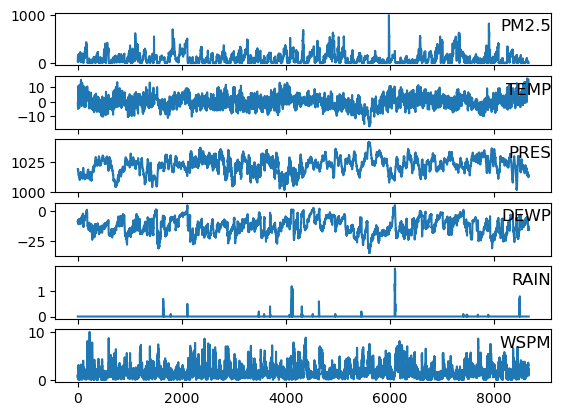

In [6]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3,  4, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
  pyplot.subplot(len(groups), 1, i)
  #print("i: " + str(i) + ", " + str(values[:,group]))
  pyplot.plot(values[:, group])
  pyplot.title(dataset.columns[group], y=0.5, loc='right')
  i += 1
pyplot.show()

In [7]:
# Multivariate LSTM Forecast Model
# Problem: predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step

# The wind direction feature is label encoded (integer encoded). This could further be one-hot encoded in the future if you are interested in exploring it
# Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
 
	# input sequence (t-n, ... t-1)
	# n_in is the number of hours as input
	for i in range(n_in, 0, -1):

		# grab row of data and appent to col
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	# n_out is the number of PM we want to predict
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	
		# drop columns we don't want to predict
		# drop next hour stats for meteorological keep PM data
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# drop columns we don't want to predict
# drop next hour stats for meteorological keep PM data
def resize(df):
  drop_list = []
  for i in range((input*7), (input+output)*7, 1):
      if (i%7 != 0):
        drop_list.append(i)
  print(drop_list)
  df.drop(reframed.columns[drop_list], axis=1, inplace=True)

In [8]:
# Preprocessing
# integer encode direction
encoder = LabelEncoder()
values[:,5] = encoder.fit_transform(values[:,5])

#print(values[:,5])
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)
#print(scaled[:,5])


(8664, 7)


In [9]:
input = 48
output = 6
# frame as supervised learning
reframed = series_to_supervised(scaled, input, output) # 48, 24
resize(reframed)
reframed.head()


# drop columns we don't want to predict
# drop next hour stats for meteorological keep PM data
# reframed.drop(reframed.columns[[8, 9,10,11,12,13]], axis=1, inplace=True)


[337, 338, 339, 340, 341, 342, 344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356, 358, 359, 360, 361, 362, 363, 365, 366, 367, 368, 369, 370, 372, 373, 374, 375, 376, 377]


,var1(t-48),var2(t-48),var3(t-48),var4(t-48),var5(t-48),var6(t-48),var7(t-48),var1(t-47),var2(t-47),var3(t-47),...,var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
48,0.033133,0.477064,0.430000,0.6550,0.0,0.923077,0.08,0.110442,0.425076,0.422501,...,0.6925,0.0,0.134615,0.11,0.230924,0.161647,0.099398,0.089357,0.080321,0.051205
49,0.110442,0.425076,0.422501,0.6525,0.0,0.134615,0.05,0.126506,0.415902,0.417500,...,0.6950,0.0,0.923077,0.12,0.161647,0.099398,0.089357,0.080321,0.051205,0.037149
50,0.126506,0.415902,0.417500,0.6600,0.0,0.826923,0.11,0.129518,0.412844,0.410000,...,0.6575,0.0,0.134615,0.18,0.099398,0.089357,0.080321,0.051205,0.037149,0.040161
51,0.129518,0.412844,0.410000,0.6825,0.0,0.865385,0.08,0.132530,0.400612,0.402498,...,0.6175,0.0,0.134615,0.27,0.089357,0.080321,0.051205,0.037149,0.040161,0.035141
52,0.132530,0.400612,0.402498,0.6600,0.0,0.653846,0.04,0.169679,0.388379,0.407499,...,0.6175,0.0,0.038462,0.19,0.080321,0.051205,0.037149,0.040161,0.035141,0.032129


In [10]:
print(reframed.values)
print(reframed.shape)
#type(train)

[[0.03313253 0.4770642  0.4300003  ... 0.08935743 0.08032128 0.05120482]
 [0.11044177 0.42507643 0.4225006  ... 0.08032128 0.05120482 0.03714859]
 [0.12650602 0.41590214 0.41749954 ... 0.05120482 0.03714859 0.04016064]
 ...
 [0.02610442 0.9235474  0.4074993  ... 0.00803213 0.01004016 0.01104418]
 [0.02008032 0.9082569  0.4074993  ... 0.01004016 0.01104418 0.00903614]
 [0.02610442 0.87461776 0.41749954 ... 0.01104418 0.00903614 0.01004016]]
(8611, 342)


In [11]:
# Define and Fit Model
# split into train and test sets
values = reframed.values
features = 7
n_train_hours = 6624
# train 75 % / test 25 %
train = values[:n_train_hours, :]

# rest is test data
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :input*features], train[:, input*features:]
test_X, test_y = test[:, :input*features], test[:, input*features:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# around 9k hours of training, 26k hours of testing

(6624, 1, 336) (6624, 6) (1987, 1, 336) (1987, 6)


In [12]:
# list1 = np.array([[1,2,3],[3,4,5],[5,6,7],[7,8,9],[9,10,11]])
# print(list1)
# print(list1[:,0 ])
# print(list1[:3, ])
# print(list1[:3, :-1])
# print(list1[:, :-1])
# print(list1[ :,-1])

In [13]:
# Create LSTM Model
# 50 neurons in first HL and 1 neuron in output layer for prediction
# input shape will be 1 time step with 7 features

# design network
import tensorflow as tf

model = tf.keras.Sequential()
# model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(tf.keras.layers.Dense(output))

2022-12-21 13:16:36.398819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
74/74 [==============================] - 11s 34ms/step - loss: 0.1278 - val_loss: 0.0840
Epoch 2/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0964 - val_loss: 0.0734
Epoch 3/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0879 - val_loss: 0.0698
Epoch 4/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0824 - val_loss: 0.0649
Epoch 5/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0783 - val_loss: 0.0631
Epoch 6/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0753 - val_loss: 0.0600
Epoch 7/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0729 - val_loss: 0.0586
Epoch 8/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0707 - val_loss: 0.0588
Epoch 9/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0691 - val_loss: 0.0576
Epoch 10/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0676 - val_loss: 0.0551
Epoch 11/50
74/74

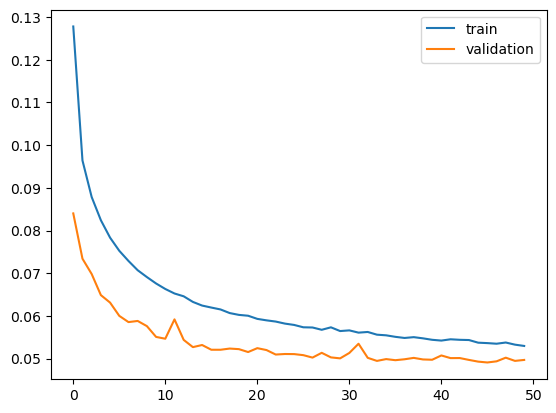

In [14]:
import keras
from keras import backend as K

input_shape = train_X.shape[1:]
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


model.compile(
    loss= root_mean_squared_error, 
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=50, 
    batch_size=72,
    validation_split=0.2
)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [15]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

test_X = test_X.reshape((test_X.shape[0], 1, input*features))

# Get prediction there can be multiple 
yhat = model.predict(test_X)

# rmse list
rmse_list = []

# this is just for inverse transform
test_X = test_X.reshape((test_X.shape[0], input*features))

to_save = np.zeros(shape=(yhat.shape[0], 1))

# calc rmse for every prediction
for i in range(yhat.shape[1]):
  # invert scaling for forecast
  inv_yhat = concatenate((yhat[:, i:i+1], test_X[:, -(features-1):]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
#   print(inv_yhat.shape)
  inv_yhat = inv_yhat[:,0]
  
  inv_yhat_reshape = np.reshape(inv_yhat, (len(inv_yhat), 1))
  to_save = np.hstack((to_save, inv_yhat_reshape))

  # invert scaling for actual
  inv_y = concatenate((test_y[:, i:i+1], test_X[:, -(features-1):]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]

  rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
  rmse_list.append(rmse)

# calculate RMSE
avg_rmse = sum(rmse_list) / len(rmse_list)
print('Test RMSE: %.3f' % avg_rmse)

to_save = to_save[:, 1:]
print(to_save.shape)
np.save('BiLSTM_pred_np_6_winter/' + display_name + "_np.npy", to_save)

63/63 [==============================] - 2s 1ms/step
Test RMSE: 66.073
(1987, 6)


In [16]:
model.save('BiLSTM_model_np_6_winter/' + display_name)

INFO:tensorflow:Assets written to: BiLSTM_model_np_6_winter/PRSA_Wanshouxigong/assets


INFO:tensorflow:Assets written to: BiLSTM_model_np_6_winter/PRSA_Wanshouxigong/assets
Exception ignored in atexit callback: <bound method InteractiveShell.atexit_operations of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x2b4994b11ea0>>
Traceback (most recent call last):
  File "/home/csci8523/jiaxx215/.conda/envs/my_tensorflow_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3800, in atexit_operations
    self._atexit_once()
  File "/home/csci8523/jiaxx215/.conda/envs/my_tensorflow_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3783, in _atexit_once
    self.history_manager.end_session()
  File "/home/csci8523/jiaxx215/.conda/envs/my_tensorflow_env/lib/python3.10/site-packages/IPython/core/history.py", line 576, in end_session
    self.writeout_cache()
  File "/home/csci8523/jiaxx215/.conda/envs/my_tensorflow_env/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/